# Time Series Predictions of COVID-19 Deaths

In [42]:
%%capture

!pip install pmdarima
!python -m pip install prophet

In [43]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt
sns.set_theme(style="darkgrid")
from statsmodels.tsa.seasonal import STL
import pmdarima as pm

from sklearn.model_selection import TimeSeriesSplit
import datetime
import requests
import warnings

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from statsmodels.tsa.deterministic import Fourier
from keras.layers import Dense
from sklearn.compose import ColumnTransformer

from keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [88]:
data_url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv'
data = pd.read_csv(data_url)
list_of_index = list(data.Date.values)
data['Date'] = pd.to_datetime(data['Date'])
data = data[(data.Country == 'US') & (data.Confirmed > 0)]
data = data[['Date', 'Confirmed', 'Deaths']]
data['New_cases'] = data['Confirmed'].diff()
data['New_deaths'] = data['Deaths'].diff()
#remove the first row because it's NaN for new columns
data = data.reset_index(drop=True).drop(0)


 **In this work will be considered only part of data: when ~50% of US citizens were fully vaccinated.** [Wiki](https://en.wikipedia.org/wiki/COVID-19_vaccination_in_the_United_States#/media/File:Vaccine_united_states.png)

In [89]:
data.set_index('Date', inplace=True)
data = data['2021-08-01':]
data.reset_index(inplace=True)
data['rolling_cases'] = data.New_cases.rolling(window=7).mean()
data['rolling_deaths'] = data.New_deaths.rolling(window=7).mean()

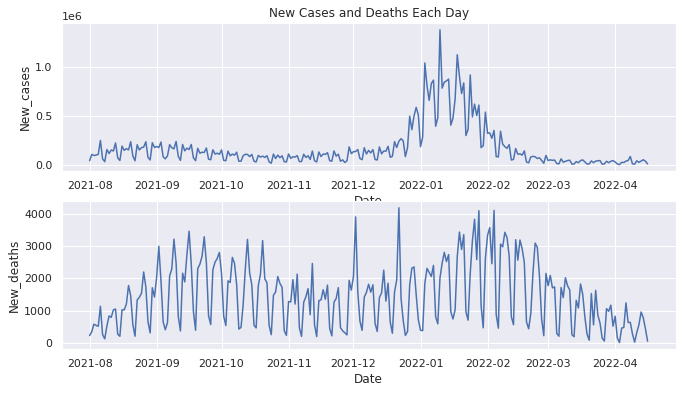

In [90]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
sns.lineplot(x="Date", y="New_cases",
             data=data, ax=ax0).set(title='New Cases and Deaths Each Day')

sns.lineplot(x="Date", y="New_deaths",
             data=data, ax=ax1)

In [91]:
px.line(data, x = 'Date', y = ['New_cases', 'rolling_cases'], title='New Cases US')

## Information from Previous Research

- Both, Death's Rate and Incidence Rate have Weekly Sesonality
- Both, Death's Rate and Incidence Rate have trends


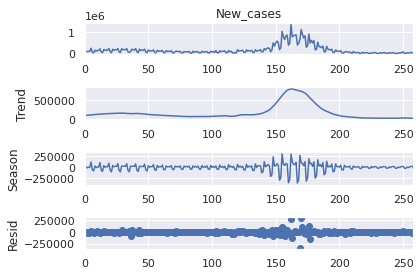

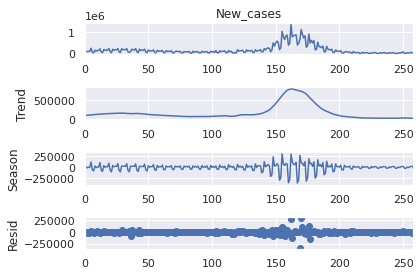

In [92]:
stl = STL(data['New_cases'], period=7).fit()
stl.plot()

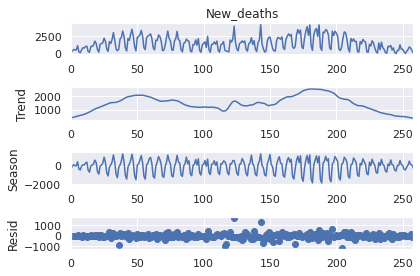

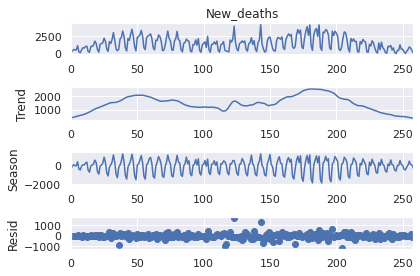

In [93]:
stl = STL(data['New_deaths'], period=7).fit()
stl.plot()

### In this work only Death's Rate is considered
 - Since after vaccination lockdown was over, huge number of people got back to citys and started and became less precautionary
 - But Death Rate acting differently, it's not growing up so sharply as infection rate

In [94]:
px.line(data, x = 'Date', y = ['New_deaths', 'rolling_deaths'])

## Identify Trend

In [95]:
data = data[['Date', 'New_deaths']]
data.set_index('Date', inplace=True)


In [96]:
# Remove 2 outliers
data.at['2021-12-02'] = data.loc['2021-12-01'].New_deaths
data.at['2021-12-22'] = data.loc['2021-12-17'].New_deaths

In [97]:
y = data.copy()
fourier = Fourier(period=250, order=3)
dp = DeterministicProcess(
    index=data.index,  # dates from the training data
    constant=True,
    period=2,  
    additional_terms=[fourier],        
    drop=True,  # drop terms to avoid collinearity
    seasonal=True,
)
X = dp.in_sample() 

In [98]:
X.head()

,const,"s(2,2)","sin(1,250)","cos(1,250)","sin(2,250)","cos(2,250)","sin(3,250)","cos(3,250)"
Date,,,,,,,,
2021-08-01,1.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2021-08-02,1.0,1.0,0.025130,0.999684,0.050244,0.998737,0.075327,0.997159
2021-08-03,1.0,0.0,0.050244,0.998737,0.100362,0.994951,0.150226,0.988652
2021-08-04,1.0,1.0,0.075327,0.997159,0.150226,0.988652,0.224271,0.974527
2021-08-05,1.0,0.0,0.100362,0.994951,0.199710,0.979855,0.297042,0.954865


In [99]:
idx_train, idx_test = train_test_split(y.index, test_size=0.2, shuffle=False)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [100]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_fitted = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns)

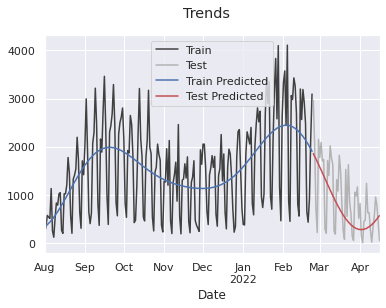

In [101]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.7', subplots=True, sharex=True, ax=axs)
axs = y_fitted.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend(['Train', 'Test', 'Train Predicted', 'Test Predicted'])
_ = plt.suptitle("Trends")

### Remove Trend 

In [102]:
train, test = y_train - y_fitted, y_test - y_pred
train['date'] = train.index
test['date'] = test.index

## Forcasting using SARIMAX
- The order: a tuple of values p, q and d. They control the number of parameters in the model. Here, let's use p=1, q=2 and d=3.

In [103]:
sar_model = SARIMAX(train['New_deaths'], order=(2, 1, 3), seasonal_order=(0,0,0,7))

In [104]:
results = sar_model.fit(disp=True)

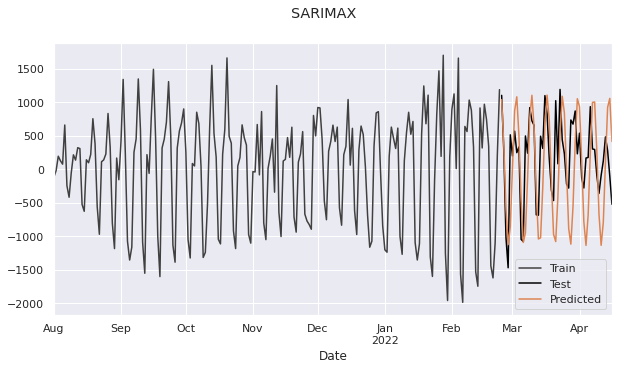

In [105]:
sarimax_prediction = results.predict(
    start=str(test.iloc[0].date)[:10], end=str(test.iloc[-1].date)[:10], dynamic=False)
plt.figure(figsize=(10, 5))
axs = train.New_deaths.plot(color='0.25', subplots=True, sharex=True)
axs = test.New_deaths.plot(color='0.0', subplots=True, sharex=True, ax=axs)
axs = sarimax_prediction.plot(color='C1', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend(['Train', 'Test', 'Predicted'])
_ = plt.suptitle("SARIMAX")


In [106]:
sar_mae = round(mean_absolute_error(sarimax_prediction, test.New_deaths), 2)
all_mae = {'SARIMAX MAE': sar_mae }
print('SARIMAX MAE = ', sar_mae)

SARIMAX MAE =  621.47


## Forcasting using Meta's Prophet Model
- Made mostly to predict business processes

In [107]:
train = train.rename(columns={'New_deaths': 'y', 'date': 'ds'})
test = test.rename(columns={'New_deaths': 'y', 'date': 'ds'})

In [108]:
prophet = Prophet(weekly_seasonality=True)
prophet.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpytsmp_ot/trks5khu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpytsmp_ot/gs8437yo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24084', 'data', 'file=/tmp/tmpytsmp_ot/trks5khu.json', 'init=/tmp/tmpytsmp_ot/gs8437yo.json', 'output', 'file=/tmp/tmpytsmp_ot/prophet_model48h_f4c0/prophet_model-20230118003551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


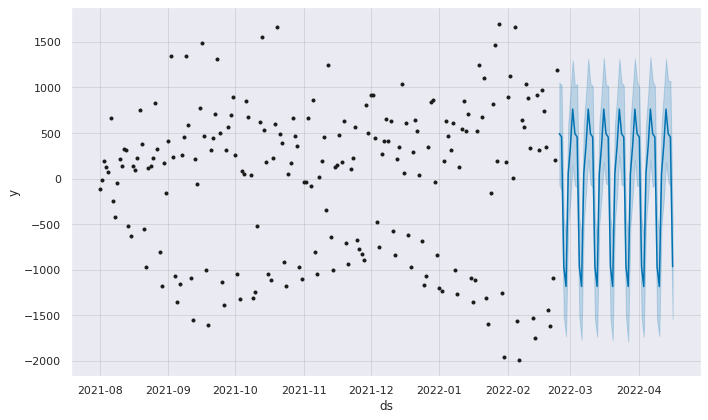

In [109]:
prophet_forecast = prophet.predict(test)
fig1 = prophet.plot(prophet_forecast)

In [110]:
prophet_forecast = prophet_forecast.set_index('ds')
prophet_future = prophet_forecast.yhat.loc['2022-02-24':]
prophet_mae = round(mean_absolute_error(prophet_future.values, test.y), 2)
all_mae['Prophet MAE'] = prophet_mae
print('Prophet MAE = ', prophet_mae)

Prophet MAE =  354.72


###Profet also working with data with trend

In [111]:
data['ds'] = data.index
data = data.rename(columns={'New_deaths': 'y'})
train_trend, test_trend = train_test_split(data, test_size=0.2, shuffle=False)

In [112]:
prophet_trend = Prophet(weekly_seasonality=True)
prophet_trend.fit(train_trend)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpytsmp_ot/n1j8w710.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpytsmp_ot/ijm9nfv2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16083', 'data', 'file=/tmp/tmpytsmp_ot/n1j8w710.json', 'init=/tmp/tmpytsmp_ot/ijm9nfv2.json', 'output', 'file=/tmp/tmpytsmp_ot/prophet_modelxqr5rhlx/prophet_model-20230118003558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


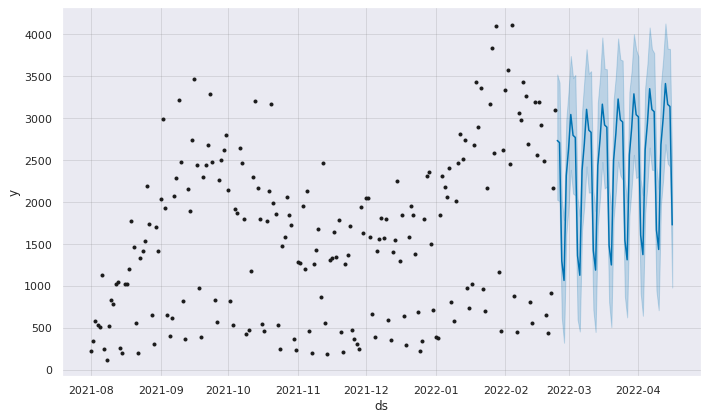

In [113]:
trend_forecast = prophet_trend.predict(test_trend)
fig2 = prophet_trend.plot(trend_forecast)

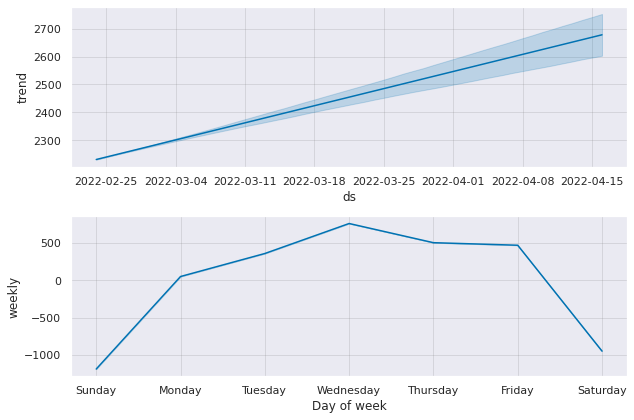

In [114]:
fig2 = prophet_trend.plot_components(trend_forecast)

In [115]:
trend_forecast = trend_forecast.set_index('ds')
prophet_trend_future = trend_forecast.yhat.loc['2022-02-24':]
trend_mae = round(mean_absolute_error(prophet_trend_future.values, test_trend.y),2)
all_mae['Prophet with Trend MAE'] = trend_mae
print('Prophet with Trend MAE = ', trend_mae)

Prophet with Trend MAE =  1526.47


## Getting Data Ready for XGBoost and NN

In [116]:
def featurize(t):
    X = pd.DataFrame()

    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.y
    return X, y


train, y_train = featurize(train)
test, y_test = featurize(test)

In [121]:
test.shape

(52, 18)

Make month and day fo week catecorical data, the rest data treat as numerical

In [117]:
num_pre = StandardScaler()
cat_pre = OneHotEncoder(handle_unknown='ignore')

num_col = ['day', 'quarter', 'dayofyear', 'weekofyear']
cat_col = ['month', 'dayofweek']

preprocesser = ColumnTransformer([
    ('num', num_pre, num_col),
    ('cat', cat_pre, cat_col)])
train = preprocesser.fit_transform(train)
test = preprocesser.transform(test)

In [118]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

## Forecasting using XGBoost Model

In [ ]:
xgb_model = XGBRegressor()
xgb_model.fit(train, y_train, 
                  eval_set=[(train, y_train), (test, y_test)],
                  verbose=True)
xgb_prediction = xgb_model.predict(test)

In [154]:
dates = pd.date_range('2022-02-24', '2022-04-16', freq='D')
xgb_prediction_df = pd.DataFrame({'Date': dates, 'Pred':xgb_prediction}).set_index('Date')

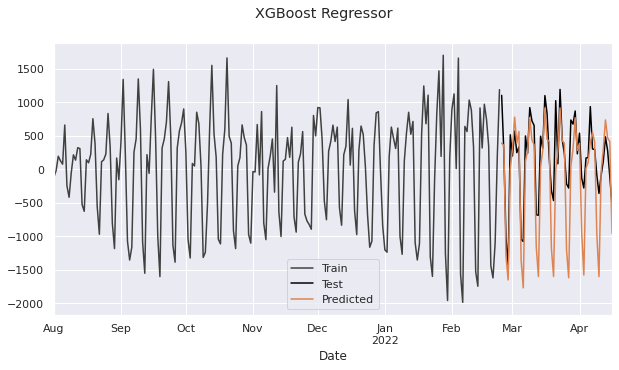

In [158]:
plt.figure(figsize=(10, 5))
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.0', subplots=True, sharex=True, ax=axs)
axs = xgb_prediction_df.plot(color='C1', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend(['Train', 'Test', 'Predicted'])
_ = plt.suptitle("XGBoost Regressor")

In [159]:
mae_xgb = round(mean_absolute_error(xgb_prediction, y_test), 2)
all_mae['XGB Regressor MAE'] = mae_xgb
print('XGBOOST MAE = ', mae_xgb)

XGBOOST MAE =  415.26


## Forecasting using Simple Neural Network

In [ ]:
NN_model = Sequential()
NN_model.add(Dense(20, input_shape=(train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
NN_model.fit(train, y_train, validation_data=(
    test, y_test), epochs=210, verbose=1)
NN_prediction = NN_model.predict(test)

In [162]:
NN_prediction_df = pd.DataFrame({'Date': dates, 'Pred': NN_prediction.squeeze()}).set_index('Date')

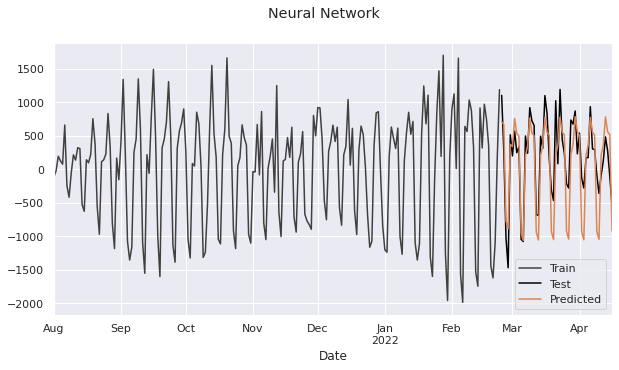

In [164]:
plt.figure(figsize=(10, 5))
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.0', subplots=True, sharex=True, ax=axs)
axs = NN_prediction_df.plot(color='C1', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend(['Train', 'Test', 'Predicted'])
_ = plt.suptitle("Neural Network")

In [165]:
nn_mae = round(mean_absolute_error(NN_prediction, y_test), 2)
all_mae['Neural Network MAE'] = nn_mae
print('NN MAE = ', nn_mae)

NN MAE =  334.04


# Summurize

In [166]:
all_mae_df = pd.DataFrame.from_dict(all_mae.items())
all_mae_df = all_mae_df.rename(columns={0: 'Name', 1: 'Value'})
all_mae_df.set_index('Name')


,Value
Name,
SARIMAX MAE,621.47
Prophet MAE,354.72
Prophet with Trend MAE,1526.47
XGB Regressor MAE,415.26
Neural Network MAE,334.04
